## Driver code generating brain-maps

### Steps
- import stat csvs 
- visualize quantitative performance  
- visualize brain regions

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import itertools
import pickle
import time

import matplotlib.pyplot as plt
import seaborn as sns

import nibabel as nib
from surfer import Brain
from mayavi import mlab

mlab.init_notebook()
mlab.options.offscreen = True

%matplotlib inline

%env SUBJECTS_DIR=/home/nikhil/projects/CT_reproduce/data/fs_test_dir/

sys.path.append('../')
from lib.plot_utils import *

Notebook initialized with x3d backend.
env: SUBJECTS_DIR=/home/nikhil/projects/CT_reproduce/data/fs_test_dir/


### Data paths

In [56]:
proj_dir = '/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/'
data_dir = proj_dir + 'data/'
results_dir = data_dir + 'results/'
brainmaps_dir = results_dir + 'brainmaps/'
demograph_file = 'ABIDE_Phenotype.csv'
sm_perf_file = 'atlas_sm_perf_DX_GROUP_QC_None_N_1047.pkl'#'atlas_sm_perf_DX_GROUP_QC_None_N_1047.pkl'

### Global Vars

In [57]:
subject_ID_col = 'SubjID'
subjects_dir = '/home/nikhil/projects/CT_reproduce/data/fs_test_dir/'
subject_id = "fsaverage"

### Load data

In [58]:
# Demographics and Dx
demograph = pd.read_csv(data_dir + demograph_file)
demograph = demograph.rename(columns={'Subject_ID':subject_ID_col})

# # Results
# atlas or pipelines
results_type = 'atlas' # atlas

if results_type == 'pipeline':
    stat_perf = pd.read_pickle(results_dir + sm_perf_file)
        
else:
    with open(results_dir + sm_perf_file, 'rb') as handle:
        stat_perf = pickle.load(handle)

### Statistical plots 

Plots based on 1047 subjects
Top 5 most significant regions             roi     t_val     p_val  p_val_corr
183    R_V2_ROI -4.670495  0.000003    0.000670
0      L_V1_ROI -4.626443  0.000004    0.000670
3      L_V2_ROI -4.345992  0.000014    0.001664
341   R_31a_ROI -3.559711  0.000371    0.033414
169  L_p10p_ROI -3.351552  0.000804    0.057859


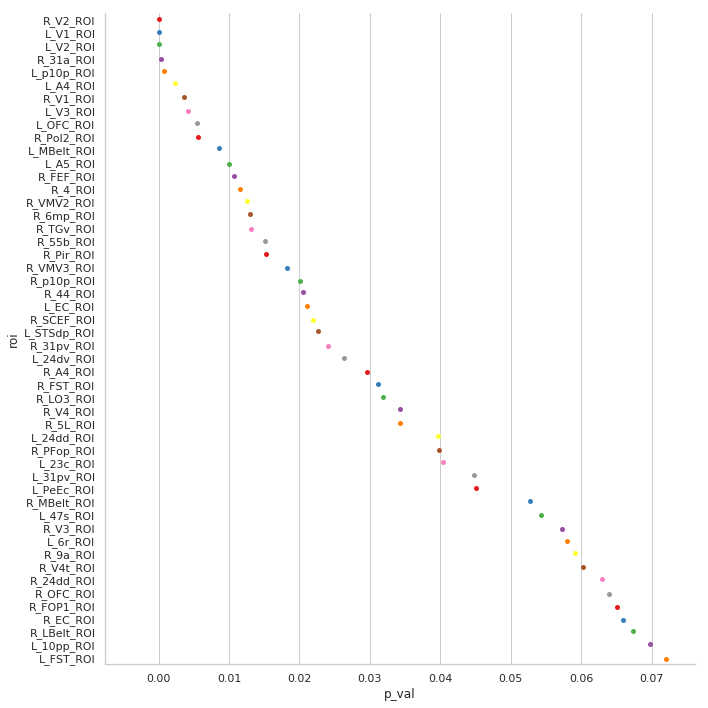

In [59]:
aparc = 'Glasser' #aparc #Destrieux #Glasser
stat_measure = 'p_val'
top_rois = 50
subx = sm_perf_file.rsplit('_',1)[1].split('.',1)[0]
print('Plots based on {} subjects'.format(subx))

if results_type == 'pipeline':
    plot_df = stat_perf.sort_values(by=[stat_measure]).head(top_rois)
    sns.set(font_scale=1)
    with sns.axes_style("whitegrid"):
        g = sns.catplot(x=stat_measure,y='roi',kind='strip',hue='pipeline',
                        data=plot_df,palette='Set1',height=10)
        #g.set(xscale="log");

else:
    plot_df = stat_perf[aparc].sort_values(by=['p_val']).head(top_rois)

    sns.set(font_scale=1)
    with sns.axes_style("whitegrid"):
        g = sns.catplot(x=stat_measure,y='roi',kind='strip',
                        data=plot_df,palette='Set1',height=10)
        #g.set(xscale="log");
        
print('Top 5 most significant regions {}'.format(plot_df.head(5)))

## PySurfer plots

In [60]:
p_thresh = 0.05

if stat_measure == 'p_val':
    mult_comp = 'no_FDR'
elif stat_measure == 'p_val_corr':
    mult_comp = 'FDR'
else:
    print('unknown multiple comparison correction')
    mult_comp = 'unknown'

    
sm_perf_filename_split = sm_perf_file.split('.',1)[0].rsplit('_',2) 
brainmap_subdir = sm_perf_filename_split[0] + '_{}_'.format(mult_comp) + sm_perf_filename_split[1] + '_' + sm_perf_filename_split[2]

save_dir = brainmaps_dir + brainmap_subdir + '/'

if results_type == 'pipeline':
    pipes = ['fs51','fs53','fs60','civet','ants']
    aparcs = ['aparc']
else:
    pipes = ['fs60']
    aparcs = ['aparc', 'Destrieux', 'Glasser']

for pipe in pipes:
    for aparc in aparcs:
        if results_type == 'pipeline':
            stat_df = stat_perf[stat_perf['pipeline']==pipe]
        else:
            stat_df = stat_perf[aparc]

        signific_rois = stat_df[stat_df[stat_measure] < p_thresh]['roi'].values
        print('Number of signficant ROIs {}'.format(len(signific_rois)))

        plot_regions_L,plot_regions_R = get_pysurfer_label_format(signific_rois,aparc)
        print('plot regions \nleft: {}, \nright: {}'.format(plot_regions_L,plot_regions_R))


        # Pysurfer parameters
        surf = 'inflated' #'white' #"inflated"
        views = ['lateral','medial']
        
        if aparc == 'Glasser':
            aparc_file = '.HCP-MMP1.annot' 
        elif aparc == 'Destrieux':
            aparc_file = '.aparc.a2009s.annot' 
        elif aparc in ['aparc', 'DKT']:
            aparc_file = '.aparc.annot'
        else:
            aparc_file = ''
            print('Unknown cortical parcellation')

        for hemi in ['lh','rh']:
            if hemi=='lh':
                signific_rois = plot_regions_L
            elif hemi=='rh':
                signific_rois = plot_regions_R
            else: 
                print('Unknown hemisphere parameter')

            for view in views:
                title = '_{}_{}_{}_{}_{}_{}_N_{}'.format(pipe,aparc,surf,hemi,view,stat_measure,subx)
                brain_fig = create_surface_plot(subject_id,hemi,surf,aparc_file,signific_rois,save_dir,title,view)
                time.sleep(5) #Mayavi messes up if called to quickly

Number of signficant ROIs 11
plot regions 
left: ['cuneus', 'entorhinal', 'lateraloccipital', 'lingual', 'medialorbitofrontal', 'pericalcarine', 'superiortemporal'], 
right: ['lateraloccipital', 'lingual', 'paracentral', 'precentral']
number of total vertices 163842 and ROIs 36
number of significant rois 7
atlas: .aparc.annot, signficant roi count: {0.0: 124803, 2.0: 1630, 3.0: 1102, 4.0: 6379, 5.0: 4205, 6.0: 2653, 7.0: 1912, 8.0: 7271, -1.0: 13887}
colormap sequential: [-1.00e+00, 3.50e+00, 8.00e+00] (opaque)
Image saved at /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/results/brainmaps/atlas_sm_perf_DX_GROUP_QC_None_no_FDR_N_1047/surf_fs60_aparc_inflated_lh_lateral_p_val_N_1047.png
number of total vertices 163842 and ROIs 36
number of significant rois 7
atlas: .aparc.annot, signficant roi count: {0.0: 124803, 2.0: 1630, 3.0: 1102, 4.0: 6379, 5.0: 4205, 6.0: 2653, 7.0: 1912, 8.0: 7271, -1.0: 13887}
colormap sequential: [-1.00e+00, 3.50e+00, 8.00e+00] (opaque)
Image 

### Create plot montage

Reading images from /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/results/brainmaps/atlas_sm_perf_DX_GROUP_QC_None_no_FDR_N_1047/
Found 12 images


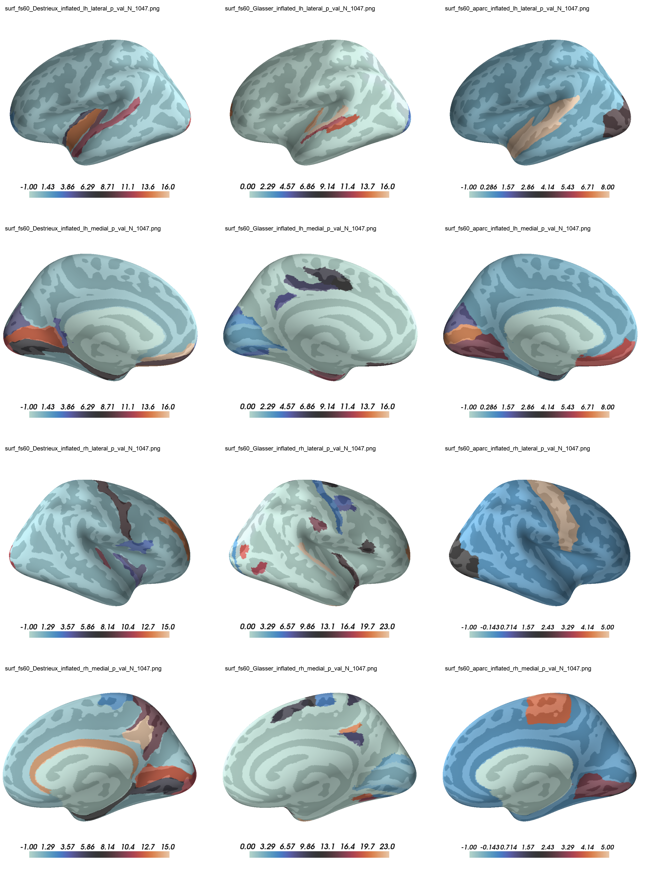

In [61]:
#save_dir = brainmaps_dir + 'atlas_sm_perf_DX_GROUP_QC_gleb_FDR_N_225/'
montage_im = createImageMontage(save_dir)
montage_im